In [705]:
import sqlite3

import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import scipy.stats

import seaborn.objects as so
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})
random_state = 42

In [706]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query_white = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result == 1
        AND p.eval is not NULL
        AND p.eval
    """

query_black = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result == -1
        AND p.eval is not NULL
        AND p.eval
    """


with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    data_white = pd.DataFrame(con.execute(query_white))
    data_black = pd.DataFrame(con.execute(query_black))
con.close()

In [729]:
# min_evals_white = -data_white.groupby("url").min()["eval"]
# min_evals_black = data_black.groupby("url").max()["eval"]
min_evals_white = -data_white["eval"]
min_evals_black = data_black["eval"]

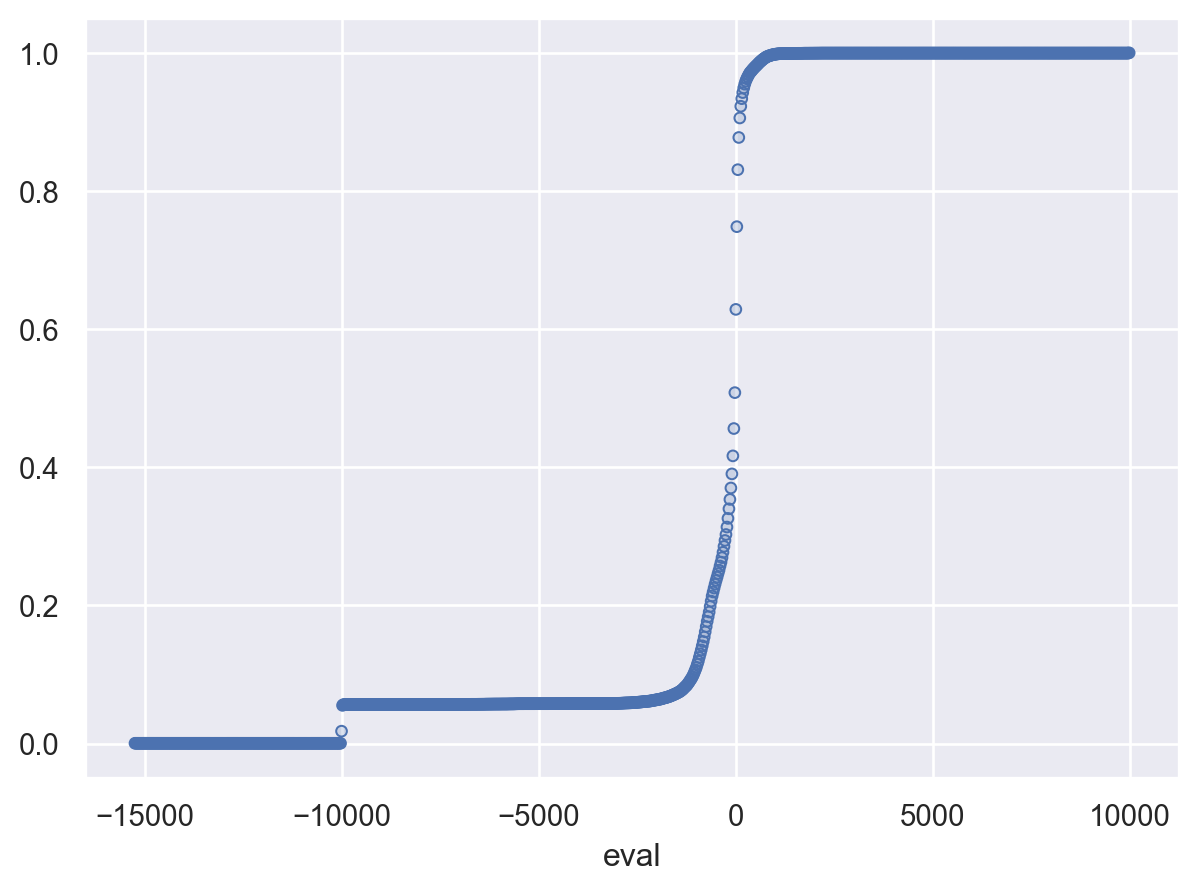

In [730]:
so.Plot(x=a).add(so.Dots(), so.Hist(cumulative=True, stat="density"))
# so.Plot(x=min_evals_black).add(so.Dots(), so.Hist(cumulative=True, stat="density"))

In [731]:
hist1 = np.histogram(-min_evals_white, bins=1000)
hist2 = np.histogram(min_evals_black, bins=1000)

In [732]:
dist1 = scipy.stats.rv_histogram(hist1)
dist2 = scipy.stats.rv_histogram(hist2)

xs = np.arange(-1000, 1000, 0.1)

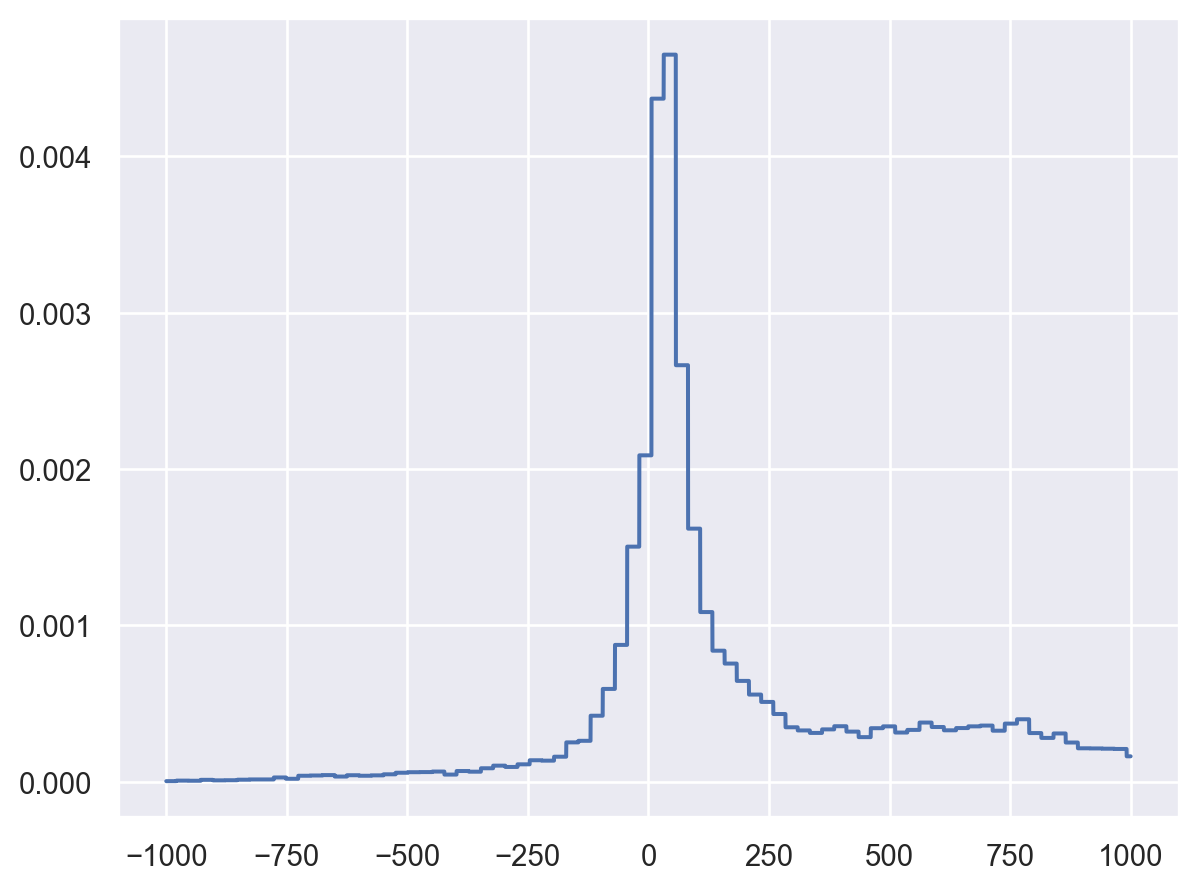

In [807]:
so.Plot(x=xs, y=dist1.pdf(xs)).add(
    so.Line(),
)

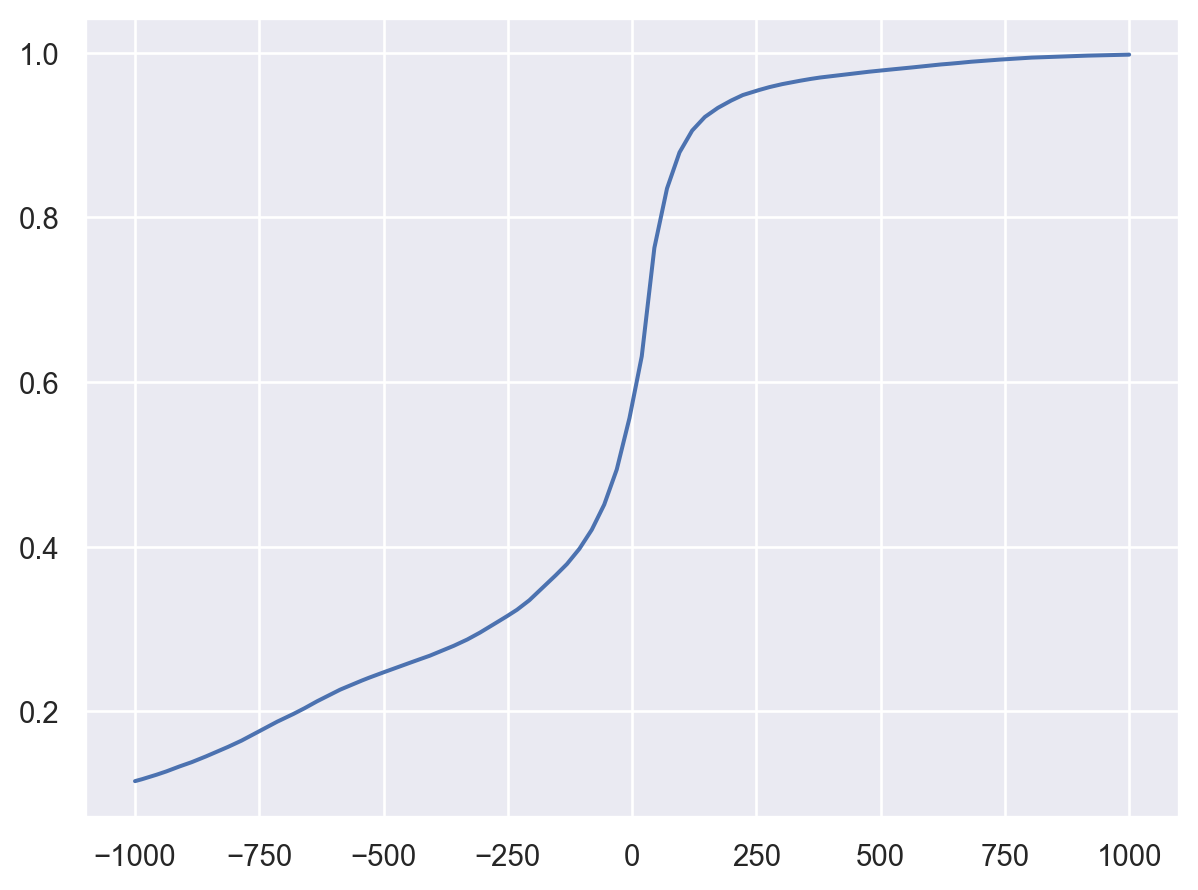

In [801]:
so.Plot(x=xs, y=dist2.cdf(xs)).add(
    so.Line(),
)

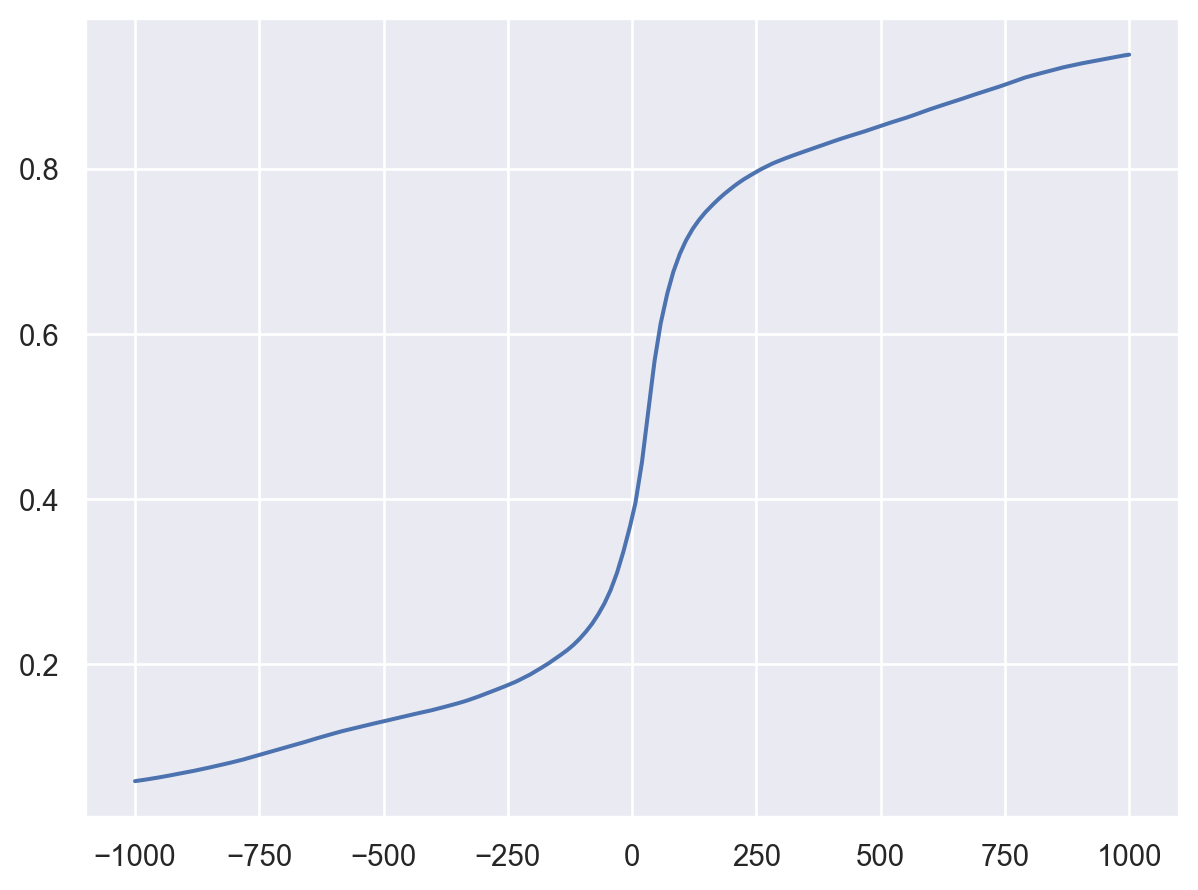

In [735]:
so.Plot(x=xs, y=(dist1.cdf(xs) + dist2.cdf(xs)) * 0.5).add(
    so.Line(),
)

In [736]:
def win_proba(cp, a):
    return 50 + 50 * (2 / (1 + np.exp(-a * cp)) - 1)

In [772]:
curve_fit(win_proba, xdata=xs, ydata=(dist1.cdf(xs) + dist2.cdf(xs)) * 0.5 * 100)

C:\Users\Sandro\AppData\Local\Temp\ipykernel_14140\2691382820.py:2: RuntimeWarning: overflow encountered in exp
  return 50 + 50 * (2 / (1 + np.exp(-a * cp)) - 1)


(array([0.0043727]), array([[1.8906e-10]]))

In [810]:
a = pd.concat([min_evals_white, min_evals_black])
# a = a[(a > -9000)]
a = data["eval"]

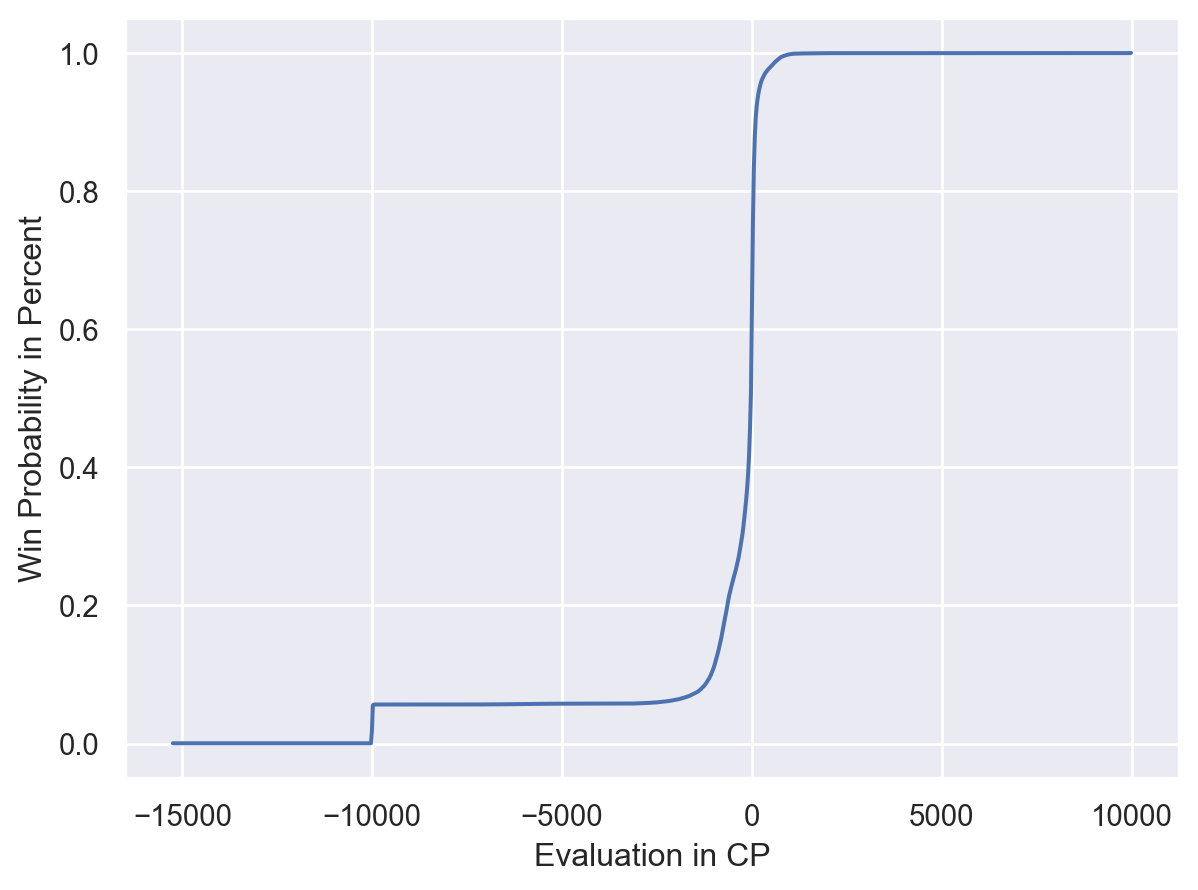

In [811]:
so.Plot(a).add(so.Line(), so.Hist(stat="probability", cumulative=True)).label(
    x="Evaluation in CP", y="Win Probability in Percent"
)

In [812]:
hist3 = np.histogram(a, bins=1000)
dist3 = scipy.stats.rv_histogram(hist3)

In [813]:

dist = scipy.stats.powernorm
dist = scipy.stats.pareto
dist = scipy.stats.lognorm

In [814]:
dist.fit(a)

d:\programme\miniconda\envs\manim-env\Lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


(0.002436962678420888, -958755.3664668016, 958045.9910340444)

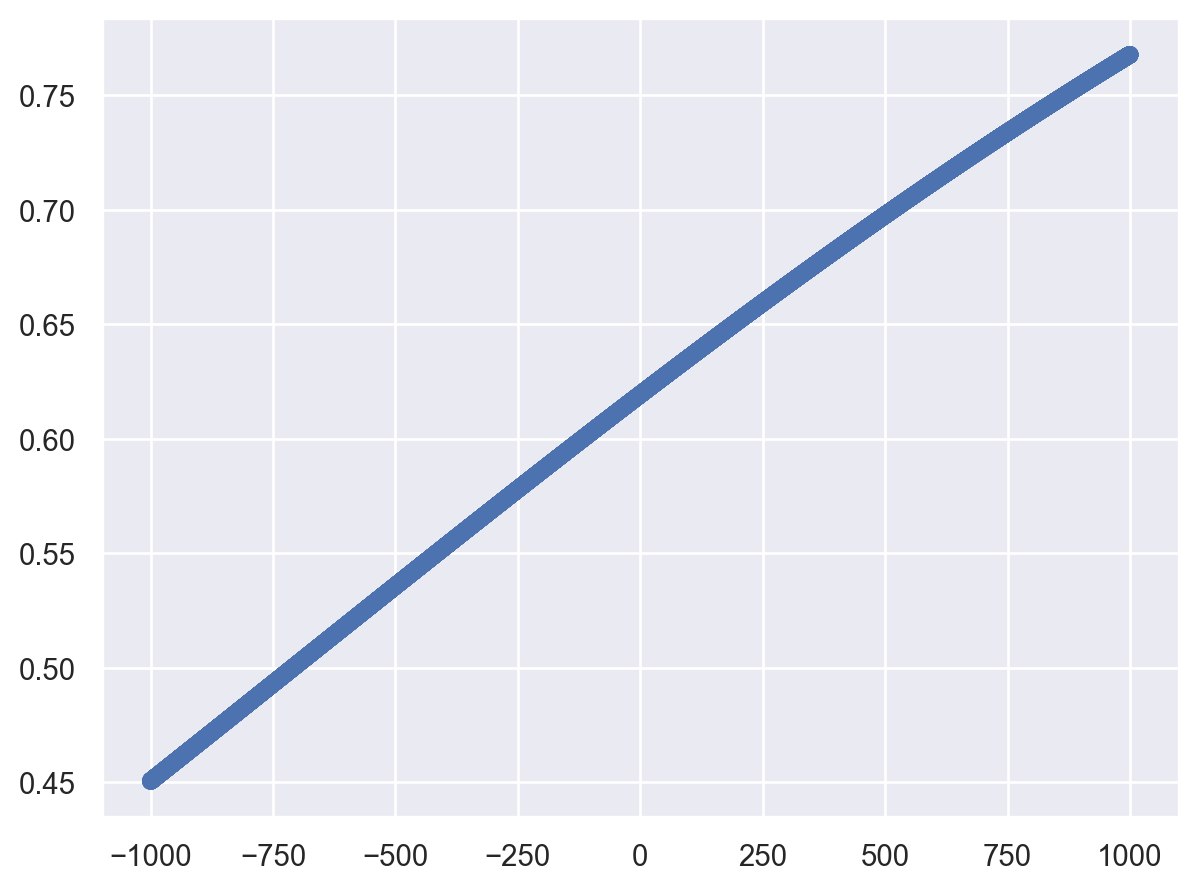

In [815]:
so.Plot(x=xs, y=dist.cdf(xs, *dist.fit(a))).add(so.Dot())

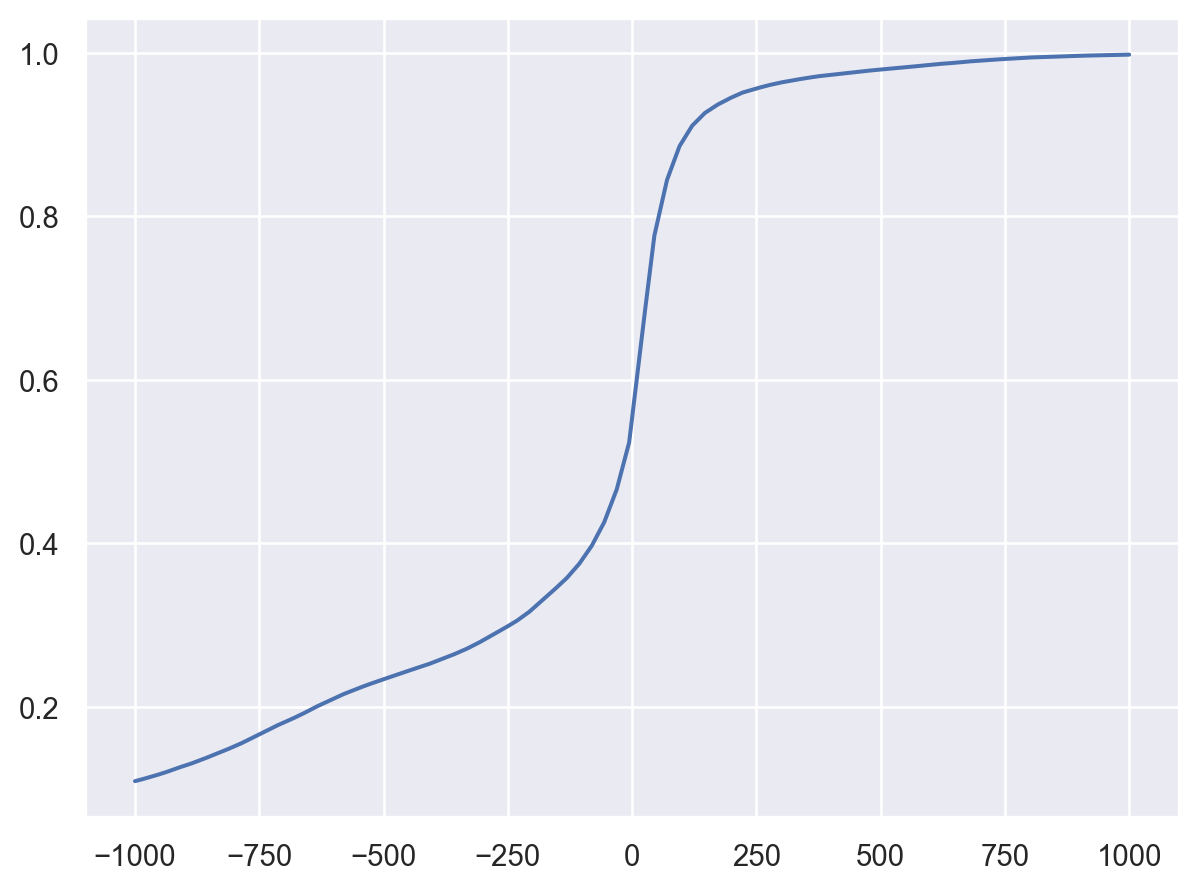

In [820]:
so.Plot(x=xs, y=dist3.cdf(xs)).add(so.Line())

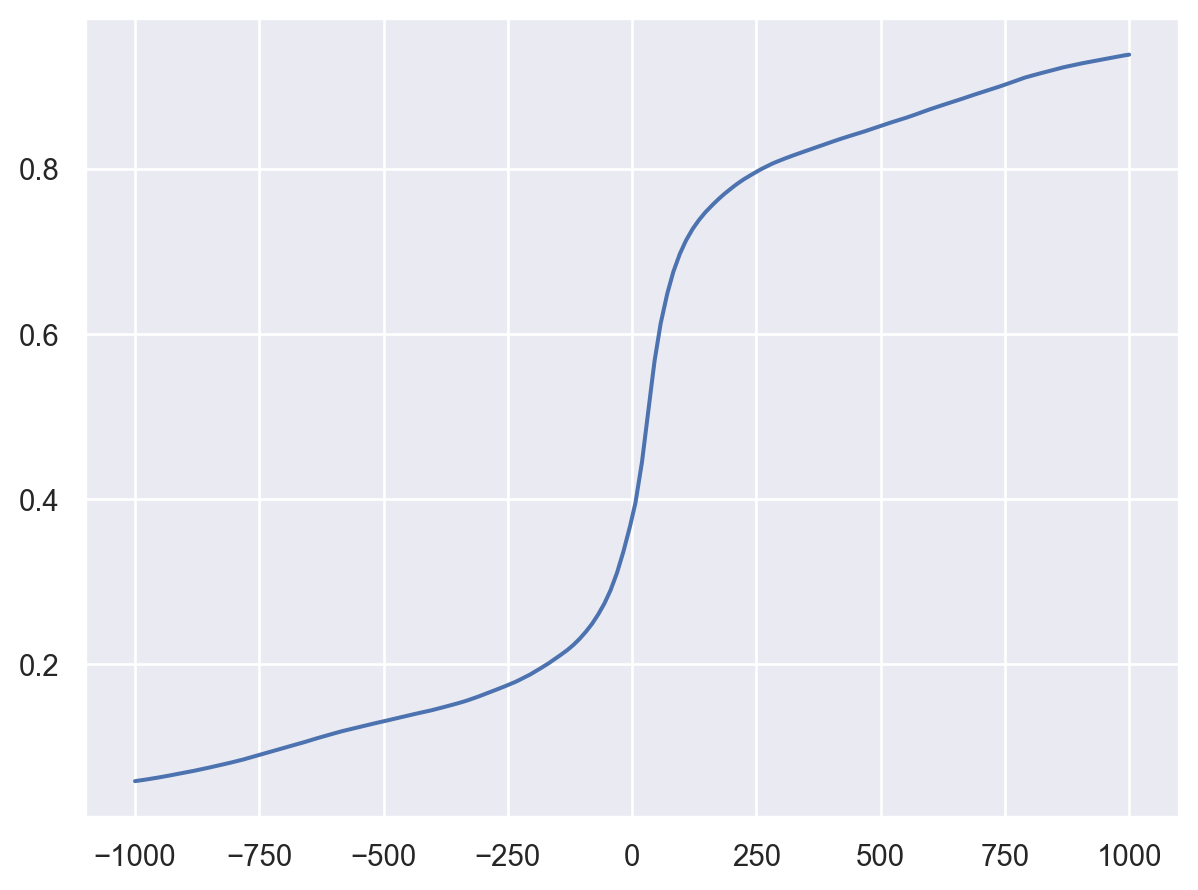

In [817]:
so.Plot(x=xs, y=(dist1.cdf(xs) + dist2.cdf(xs)) * 0.5).add(
    so.Line(),
)

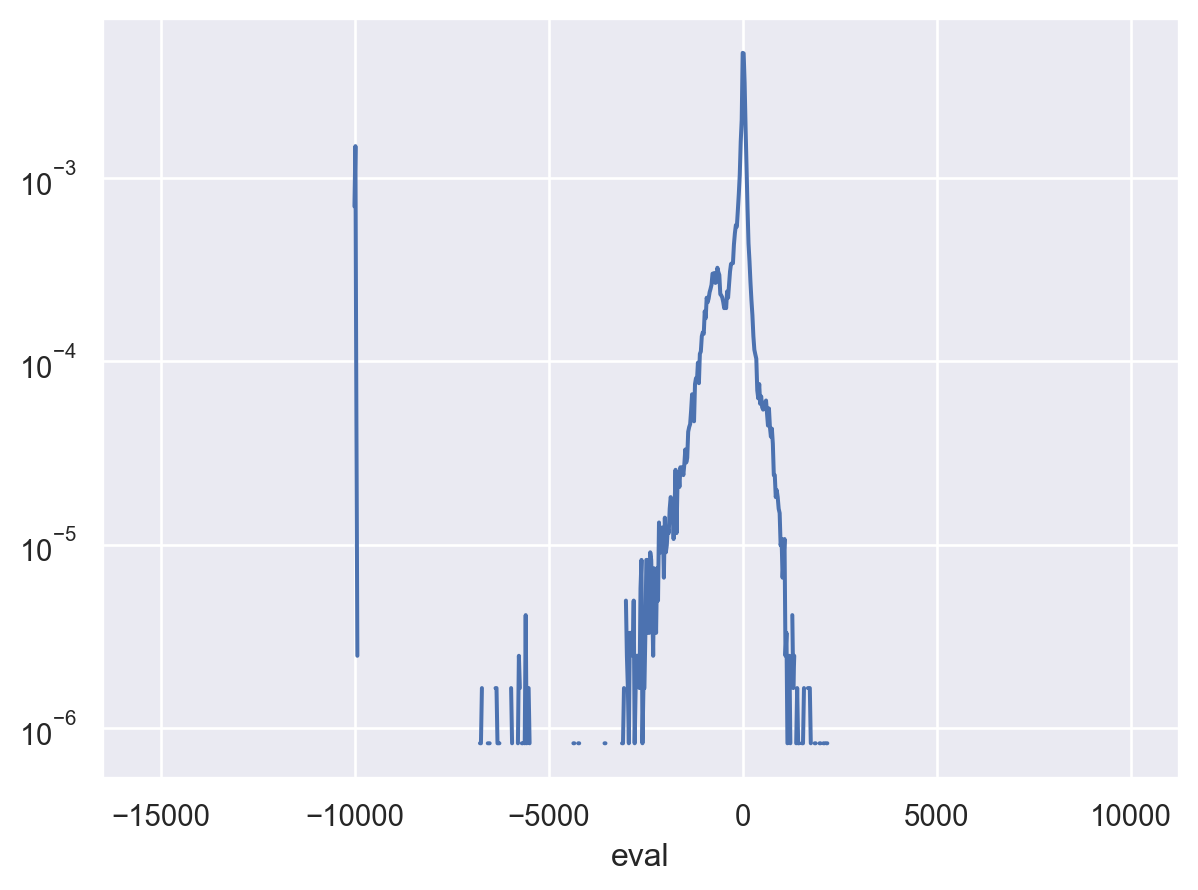

In [821]:
so.Plot(a).add(so.Lines(), so.Hist(stat="density", cumulative=False)).scale(y="log")

In [819]:
scipy.stats.ks_1samp(
    np.histogram(a, bins=100)[0], dist.cdf, dist.fit(a), alternative="two_sided"
)

d:\programme\miniconda\envs\manim-env\Lib\site-packages\scipy\stats\_continuous_distns.py:6617: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


KstestResult(statistic=0.6193311970207649, pvalue=1.6939784503426142e-37, statistic_location=0, statistic_sign=-1)